<a href="https://colab.research.google.com/github/Harriet101-alt/RimbaRaya-NDVI-Analysis/blob/main/dissmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install earthengine-api folium ipywidgets # ipywidgets for better folium integration in notebooks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00


In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='my-project-dissertation-464420')

In [7]:
import ee
import folium # For interactive mapping in a Jupyter/Colab environment
import ipywidgets as widgets
from ipyleaflet import Map, TileLayer, WidgetControl, LayersControl

# Initialize Earth Engine (assuming it's already initialized in a previous cell with a project)
# The previous cell successfully initialized Earth Engine, so we don't need to do it again here.
# try:
#     ee.Initialize()
#     print("Earth Engine initialized successfully!")
# except ee.EEException as e:
#     print(f"Earth Engine initialization failed: {e}")
#     print("Please authenticate your GEE account. If you're running this for the first time,")
#     print("you might need to run 'earthengine authenticate' in your terminal.")
    # Exit or handle the error appropriately if initialization fails
    # exit()

# Define Rimba Raya AOI as a polygon
aoi = ee.Geometry.Polygon([
  [
    [112.020, -2.5],
    [112.470, -2.5],
    [112.470, -3.35],
    [112.020, -3.35],
    [112.020, -2.5]  # closing the ring
  ]
])

# --- Functions for Landsat Preprocessing ---

# Function to apply scale factors to Landsat Collection 2, Level 2 images (SR and ST bands).
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

# Function to mask clouds and shadows in Landsat 8 Collection 2, Level 2 images (QA_PIXEL band).
def cloud_mask_l8(image):
  qa_pixel = image.select('QA_PIXEL')
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloud_shadow_bitmask = 1 << 3
  clouds_bitmask = 1 << 5
  # Both flags should be zero, indicating clear conditions.
  mask = qa_pixel.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
         qa_pixel.bitwiseAnd(clouds_bitmask).eq(0))
  return image.updateMask(mask)

# Function to mask clouds and shadows in Landsat 5 Collection 2, Level 2 images (QA_PIXEL band).
def cloud_mask_l5(image):
  qa_pixel = image.select('QA_PIXEL')
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloud_shadow_bitmask = 1 << 3
  clouds_bitmask = 1 << 5
  # Both flags should be zero, indicating clear conditions.
  mask = qa_pixel.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
         qa_pixel.bitwiseAnd(clouds_bitmask).eq(0))
  return image.updateMask(mask)

# Function to calculate NDVI for Landsat imagery.
# Assumes bands have been renamed to 'NIR' and 'Red'.
def calculate_ndvi(image):
  ndvi = image.normalizedDifference(['NIR', 'Red']).rename('NDVI')
  return image.addBands(ndvi)

# --- Define Time Period ---
start_year = 2008
end_year = 2025 # Data up to June 30, 2025

# Define yearsList (ee.List)
years_list = ee.List.sequence(start_year, end_year)
# print('Raw yearsList (EE Object):', years_list.getInfo()) # DEBUG with .getInfo()

# --- Load and Preprocess Landsat Data for the entire period ---
all_landsat = ee.ImageCollection([]) # Empty collection to start

# Landsat 5 (Operational 1984-03-01 to 2012-05-05 for C2L2)
collection_l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
  .filterDate(str(start_year) + '-01-01', '2012-12-31') \
  .filterBounds(aoi)

# print('L5 Raw collection size:', collection_l5.size().getInfo()) # DEBUG
collection_l5 = collection_l5 \
  .map(apply_scale_factors) \
  .map(cloud_mask_l5) \
  .select(['SR_B4', 'SR_B3', 'QA_PIXEL'], ['NIR', 'Red', 'QA_PIXEL'])
# print('L5 After processing and band selection size:', collection_l5.size().getInfo()) # DEBUG
all_landsat = all_landsat.merge(collection_l5)

# Landsat 8 (Operational 2013-04-11 to present for C2L2)
collection_l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2013-01-01', str(end_year) + '-06-30') \
  .filterBounds(aoi)

# print('L8 Raw collection size:', collection_l8.size().getInfo()) # DEBUG
collection_l8 = collection_l8 \
  .map(apply_scale_factors) \
  .map(cloud_mask_l8) \
  .select(['SR_B5', 'SR_B4', 'QA_PIXEL'], ['NIR', 'Red', 'QA_PIXEL'])
# print('L8 After processing and band selection size:', collection_l8.size().getInfo()) # DEBUG
all_landsat = all_landsat.merge(collection_l8)

# print('Merged Landsat collection size (before NDVI calculation):', all_landsat.size().getInfo()) # DEBUG

# Calculate NDVI for the merged collection and select only the NDVI band
ndvi_collection = all_landsat.map(calculate_ndvi).select('NDVI')
# print('NDVI collection size (after NDVI calculation):', ndvi_collection.size().getInfo()) # DEBUG


# --- Visualization Parameters ---

# Visualization for individual year's NDVI (if you want to see them)
ndvi_vis = {
  'min': 0.1,   # Typical min for dense vegetation
  'max': 0.8,   # Typical max for dense vegetation
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163',
    '99B718', '74A901', '66A000', '529400', '3e8601'
  ]
}

# Visualization for NDVI difference (diverging palette)
# Red for decrease, white for no change, green for increase
diff_vis = {
  'min': -0.2, # Adjust these based on expected magnitude of change
  'max': 0.2,  # A common range for NDVI change, can be adjusted for more contrast
  'palette': ['red', 'orange', 'yellow', 'white', 'lightgreen', 'green', 'darkgreen']
}


# --- Step 1: Compute Annual Median NDVI Images (Robust GEE Way) ---
# Note: In Python, you can often define a lambda or a nested function for map,
# or define a top-level function like apply_scale_factors. Here we use a regular function.
def compute_annual_median_ndvi(year_ee):
  year_ee = ee.Number(year_ee)

  year_string = year_ee.format('%d')

  end_date_current_year = ee.Algorithms.If(
    year_ee.eq(2025),
    year_string.cat('-06-30'),
    year_string.cat('-12-31')
  )

  start_date_current_year = year_string.cat('-01-01')

  year_collection = ndvi_collection \
    .filterDate(start_date_current_year, end_date_current_year)

  # DEBUG: Use server-side string concatenation for print statements within map
  # In Python, print inside a map function doesn't work directly like JS `print`.
  # You'd typically print sizes *after* mapping, or use .getInfo() if truly needed.
  # For demonstration, we'll keep the .getInfo() for direct debugging.
  # print(ee.String('Collection for ').cat(year_string).cat(' before median() size:').cat(year_collection.size().format()).getInfo()) # REMOVED .getInfo()

  median_ndvi = ee.Algorithms.If(
    year_collection.size().gt(0),
    year_collection.median().select('NDVI'),
    ee.Image(0).rename('NDVI').selfMask()
  )

  return ee.Image(median_ndvi).set('year', year_ee)

annual_median_ndvi_images_list = years_list.map(compute_annual_median_ndvi)


# NEW DEBUGGING: Evaluate the lists before creating the dictionary
# In Python, we use .getInfo() to evaluate. This is a synchronous call.
# Ensure keys are consistent strings (e.g., '2008', '2009', etc.)
keys = years_list.map(lambda year: ee.String(ee.Number(year).format('%d'))).getInfo()
if not keys:
    print('Error evaluating yearsList keys: Keys list is empty or evaluation failed.')
else:
    print('Client-side yearsList keys (strings):', keys) # Should contain '2025'

    images = annual_median_ndvi_images_list.getInfo()
    if not images:
        print('Error evaluating annualMedianNdviImagesList: Images list is empty or evaluation failed.')
    else:
        print('Client-side annualMedianNdviImagesList (contains image IDs/properties):', images)
        print('Length of client-side annualMedianNdviImagesList:', len(images))
        print('Expected length (endYear - startYear + 1):', end_year - start_year + 1)

        # Only proceed to create the dictionary and the next loop if evaluations succeed
        if len(keys) == len(images) and len(keys) == (end_year - start_year + 1):
            # Create ee.Dictionary from ee.List objects
            # Use the consistently formatted string keys
            annual_median_ndvi_images = ee.Dictionary.fromLists(
              years_list.map(lambda year: ee.String(ee.Number(year).format('%d'))), # Keys as ee.String (e.g., '2008')
              annual_median_ndvi_images_list # Values as ee.Image
            )

            print('Annual Median NDVI Images dictionary (server-side, GEE idiomatic):', annual_median_ndvi_images.getInfo())

            # NEW DEBUG: Check specific key after the dictionary creation, to ensure it's in the dictionary
            contains_end_year = annual_median_ndvi_images.contains(str(end_year)).getInfo()
            print(f'Is {end_year} key in dictionary?', contains_end_year)
            if contains_end_year:
                value_for_end_year = annual_median_ndvi_images.get(str(end_year)).getInfo()
                print(f'Value for {end_year} in dictionary:', value_for_end_year)

                # --- Step 2: Calculate Consecutive Year NDVI Differences (Server-Side) ---
                # This entire section is now nested inside the evaluation callbacks
                # This ensures `annual_median_ndvi_images` is fully resolved before used here.

                ndvi_difference_images_list = ee.List([])

                # Use a client-side for loop, as 'annual_median_ndvi_images' is now client-side
                for i in range(start_year, end_year): # Python range excludes the end_year
                    current_year1 = i
                    current_year2 = i + 1

                    # Cast to ee.Image as .get() returns an ee.Object
                    # Use consistent string keys
                    ndvi_year1 = ee.Image(annual_median_ndvi_images.get(str(current_year1)))
                    ndvi_year2 = ee.Image(annual_median_ndvi_images.get(str(current_year2)))

                    # Perform the subtraction.
                    ndvi_difference = ndvi_year2.subtract(ndvi_year1).rename('NDVI_Change')

                    # Add metadata (year1, year2) as properties to the image.
                    ndvi_difference = ndvi_difference.set({
                      'year1': current_year1,
                      'year2': current_year2,
                      'name': f'NDVI Change {current_year2}-{current_year1}'
                    })

                    # Add this annotated difference image to the list
                    ndvi_difference_images_list = ndvi_difference_images_list.add(ndvi_difference)

                # Evaluate the list of difference images once after the loop
                client_list_diff_images = ndvi_difference_images_list.getInfo() # Evaluate here
                if not client_list_diff_images:
                    print('*** List (ERROR) Details for Difference Images: ***')
                    print('Error evaluating NDVI difference images list: List is empty or evaluation failed.')
                    print('************************************************')
                else:
                    print('Client-side list of difference image properties (first 5 elements):', client_list_diff_images[:5])

                    # Create a Folium map centered on the AOI
                    map_center = aoi.centroid().coordinates().reverse().getInfo()
                    m = folium.Map(location=map_center, zoom_start=10)

                    # Add AOI to map
                    folium.GeoJson(aoi.getInfo(), name='Rimba Raya AOI', style_function=lambda x: {'color': 'red'}).add_to(m)


                    for image_properties in client_list_diff_images:
                        # Ensure image_properties and image_properties['id'] are valid before proceeding
                        # Access 'id' at the top level of the dictionary
                        if not image_properties or 'id' not in image_properties:
                            print('Skipping layer: Invalid image properties or ID for a difference image.')
                            continue

                        ee_image = ee.Image(image_properties['id'])
                        layer_name = image_properties['properties']['name'] # Access properties from dict

                        # Perform a reduceRegion to count non-masked pixels as a final check before adding layer
                        count_result = ee_image.reduceRegion(
                            reducer=ee.Reducer.count(),
                            geometry=aoi,
                            scale=30, # Use appropriate scale for your data (e.g., 30m for Landsat)
                            maxPixels=1e9 # Increase maxPixels if needed for large AOIs
                        ).get('NDVI_Change').getInfo()

                        if count_result and count_result > 0: # Check if count is not None and greater than 0
                            # Get the map ID and token from the Earth Engine image
                            map_id_dict = ee_image.getMapId(diff_vis)
                            tile_url = map_id_dict['tile_fetcher'].url_format

                            # Add the Earth Engine layer to the Folium map using TileLayer
                            folium.TileLayer(
                                tiles=tile_url,
                                attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                                name=layer_name,
                                overlay=True,
                                control=True
                            ).add_to(m)

                            print(f'Added layer: {layer_name} (Pixels: {count_result})')
                        else:
                            print(f'No data to display for: {layer_name} (No valid pixels or empty composite)')

                    # Add layer control to the map
                    folium.LayerControl().add_to(m)
                    # Display the map (if in a Jupyter/Colab environment)
                    display(m)

            else:
                print(f'Key {end_year} not found in dictionary.')
        else:
            print('Mismatch in list lengths. Dictionary will not be created correctly.')
            print('Years keys length:', len(keys))
            print('Images list length:', len(images))
            print('This typically means that `annualMedianNdviImagesList.map` failed for some years, resulting in fewer images than expected.')

# --- Optional: Add an overall Median NDVI map for the entire period as a baseline ---
overall_median_ndvi = ndvi_collection.median().select('NDVI').clip(aoi)

# Add overall median NDVI layer
# This converts the GEE image to a thumbnail URL for Folium
map_center = aoi.centroid().coordinates().reverse().getInfo()
m_overall = folium.Map(location=map_center, zoom_start=10)
folium.GeoJson(aoi.getInfo(), name='Rimba Raya AOI', style_function=lambda x: {'color': 'red'}).add_to(m_overall)

# Get the map ID and token for the overall median NDVI image
map_id_dict_overall = overall_median_ndvi.getMapId(ndvi_vis)
tile_url_overall = map_id_dict_overall['tile_fetcher'].url_format

# Add the overall median NDVI layer to the Folium map using TileLayer
folium.TileLayer(
    tiles=tile_url_overall,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name=f'Overall Median NDVI ({start_year}-{end_year})',
    overlay=True,
    control=True
).add_to(m_overall)

folium.LayerControl().add_to(m_overall)
display(m_overall)
tile_urls = {}
for y in range(start_year, end_year + 1):
    # Use consistent string key format
    y_key = str(y)
    # Get EE image for the year
    # Use consistent string key format
    ee_img = ee.Image(annual_median_ndvi_images.get(y_key))
    # Get tile URL for folium/ipyleaflet
    try:
        map_id = ee_img.getMapId(ndvi_vis)
        tile_urls[y] = map_id['tile_fetcher'].url_format
    except Exception as e:
        print(f"Could not get tile URL for year {y}: {e}")

# Step 2: Build the slider map
years = sorted(tile_urls.keys())
if years:
    center = map_center  # Already computed earlier
    m_slider = Map(center=center, zoom=10, scroll_wheel_zoom=True)

    # Prepare layers for each year
    tile_layers = {}
    for year in years:
        t = TileLayer(url=tile_urls[year], name=str(year), opacity=1 if year==years[0] else 0)
        tile_layers[year] = t
        m_slider.add_layer(t)

    m_slider.add_control(LayersControl(position='topright'))

    slider = widgets.IntSlider(
        value=years[0],
        min=years[0],
        max=years[-1],
        step=1,
        description='Year:',
        continuous_update=False
    )

    def on_year_change(change):
        for y in years:
            tile_layers[y].opacity = 1 if y == change['new'] else 0

    slider.observe(on_year_change, names='value')
    slider_control = WidgetControl(widget=slider, position='topright')
    m_slider.add_control(slider_control)

    display(m_slider)
else:
    print("No annual NDVI tile URLs available for slider map.")

print('Script complete. Check the map for NDVI change layers and Console for debug messages.')

Client-side yearsList keys (strings): ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']
Client-side annualMedianNdviImagesList (contains image IDs/properties): [{'type': 'Image', 'bands': [{'id': 'NDVI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'year': 2008}}, {'type': 'Image', 'bands': [{'id': 'NDVI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'year': 2009}}, {'type': 'Image', 'bands': [{'id': 'NDVI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'year': 2010}}, {'type': 'Image', 'bands': [{'id': 'NDVI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -

Map(center=[-2.9249688189236043, 112.24500000000013], controls=(ZoomControl(options=['position', 'zoom_in_text…

Script complete. Check the map for NDVI change layers and Console for debug messages.


# Task
Generate a graph of the mean annual NDVI difference from the 2008 baseline for the Rimba Raya region from 2009 to 2025.

## Calculate annual ndvi differences from baseline

### Subtask:
Compute the difference between the annual median NDVI image of each year (from 2009 to 2025) and the 2008 annual median NDVI image.


**Reasoning**:
The previous code successfully calculated the annual median NDVI images and stored them in an ee.Dictionary. However, the client-side evaluation showed that the key for the end year (2025) was not found in the dictionary, likely due to an issue in the client-side handling after getInfo(). To perform the next step, which is calculating the difference from the 2008 baseline, it's better to work directly with the server-side ee.Dictionary `annual_median_ndvi_images`. The instructions ask to iterate from 2009 to 2025, which can be done using a server-side map function over a sequence of years. I will retrieve the 2008 image, create a list of years from 2009 to 2025, and then map a function over this list to calculate the difference for each year from the 2008 baseline and add properties.



## Calculate mean ndvi difference per year

### Subtask:
For each annual difference image, calculate the mean NDVI difference within the Rimba Raya AOI.


**Reasoning**:
Define a function to calculate the mean NDVI difference for a given difference image and then map this function over the list of annual difference images.



**Reasoning**:
The traceback indicates an `EEException: Dictionary.get: Dictionary does not contain key: '2008'.`. This error originates from the previous subtask's code when `annual_median_ndvi_images.get(str(start_year))` was called inside the `calculate_baseline_difference` function, which is mapped over the years 2009-2025. The dictionary `annual_median_ndvi_images` uses string keys derived from the years. The error suggests that when processing one of the years in the `years_to_diff` list (2009-2025), the function implicitly tries to get the '2008' key from `annual_median_ndvi_images` *again* within the map, but it seems the context or definition of `ndvi_2008_baseline` is not correctly available or evaluated at that point in the server-side map execution. The 2008 baseline image was defined *outside* the mapped function, which is the correct approach, but the error persists.

Looking closely at the previous subtask's code, the issue might be in how the baseline is referenced inside the `calculate_baseline_difference` function within the `map`. While `ndvi_2008_baseline` is defined globally, the server-side `map` function needs to capture or reference it correctly. A robust way to handle this in GEE is to pass the baseline image explicitly into the mapped function if possible, or ensure the global variable is accessible. However, since the 2008 baseline is a single image and is already defined, the problem might stem from GEE's execution context during the map.

A different approach to computing the differences might be more stable: explicitly subtracting the baseline image from each image in the *list* of annual images (from 2009 onwards) *before* mapping the mean calculation. This ensures the subtraction happens correctly with the baseline image.

Let's redefine the list of images we need to calculate the difference from baseline for, then calculate the differences, and finally map the mean calculation.

First, create an `ee.List` of the annual median NDVI images for years 2009 through 2025. Then, iterate through this list, subtract the 2008 baseline from each image, and add the result to a new list of difference images. Finally, map the mean calculation over this new list.



In [10]:
# Subtask: Calculate mean NDVI difference per year from the 2008 baseline.

# Get the 2008 baseline NDVI image.
# Ensure the key '2008' is used as a string to access the dictionary
ndvi_2008_baseline = ee.Image(annual_median_ndvi_images.get('2008'))

# Create a list of years from 2009 to the end_year for calculating differences.
years_to_diff = ee.List.sequence(start_year + 1, end_year)

# Function to calculate the difference from the 2008 baseline and compute the mean.
def calculate_mean_difference(year_ee):
    year_ee = ee.Number(year_ee)
    year_string = year_ee.format('%d')

    # Get the annual median NDVI image for the current year.
    # Ensure the key is used as a string
    current_year_ndvi = ee.Image(annual_median_ndvi_images.get(year_string))

    # Calculate the difference from the 2008 baseline.
    # Use .unmask() to ensure the subtraction includes areas that might be masked in one image but not the other.
    # Then .clip() back to the AOI.
    ndvi_difference = current_year_ndvi.subtract(ndvi_2008_baseline).rename('NDVI_Change').clip(aoi)

    # Calculate the mean NDVI difference within the AOI.
    mean_diff_dict = ndvi_difference.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30, # Use appropriate scale for your data (e.g., 30m for Landsat)
        maxPixels=1e9 # Increase maxPixels if needed for large AOIs
    )

    # Get the mean value, checking if the key exists.
    mean_diff = mean_diff_dict.get('NDVI_Change')

    # Return a feature with properties for the year and the mean difference.
    # Include the feature only if mean_diff is not None or a sentinel value indicating failure
    return ee.Feature(None, {'year': year_ee, 'mean_ndvi_difference': mean_diff})


# Map the function over the years to get a list of features with mean differences.
mean_ndvi_differences_features = years_to_diff.map(calculate_mean_difference)

# Convert the list of features to a FeatureCollection.
mean_ndvi_differences_collection = ee.FeatureCollection(mean_ndvi_differences_features)

# Fetch the results to the client side for plotting.
# Use .getInfo() to evaluate the server-side object and get the data.
mean_ndvi_differences_list = mean_ndvi_differences_collection.getInfo()['features']

# Process the fetched data into a format suitable for plotting (e.g., a list of dictionaries).
# Filter out features where the mean_ndvi_difference was not successfully calculated (e.g., is None or a sentinel value).
chart_data = [{'year': f['properties']['year'], 'mean_ndvi_difference': f['properties']['mean_ndvi_difference']} for f in mean_ndvi_differences_list if f['properties'].get('mean_ndvi_difference') is not None]

# Print the processed data (optional).
import pprint
pprint.pprint(chart_data)

[{'mean_ndvi_difference': -0.018630234264937626, 'year': 2009},
 {'mean_ndvi_difference': 0.017280197001139624, 'year': 2010},
 {'mean_ndvi_difference': -0.15716247386744486, 'year': 2011},
 {'mean_ndvi_difference': 0.12213270194244488, 'year': 2013},
 {'mean_ndvi_difference': 0.10843348072126854, 'year': 2014},
 {'mean_ndvi_difference': 0.09092903693125386, 'year': 2015},
 {'mean_ndvi_difference': 0.10859368587521591, 'year': 2016},
 {'mean_ndvi_difference': 0.11810737118084426, 'year': 2017},
 {'mean_ndvi_difference': 0.10290149255539639, 'year': 2018},
 {'mean_ndvi_difference': 0.10554850199628533, 'year': 2019},
 {'mean_ndvi_difference': 0.13822838975379653, 'year': 2020},
 {'mean_ndvi_difference': 0.1364492329006469, 'year': 2021},
 {'mean_ndvi_difference': 0.13238438515217457, 'year': 2022},
 {'mean_ndvi_difference': 0.1201377721622696, 'year': 2023},
 {'mean_ndvi_difference': 0.1328389961335962, 'year': 2024},
 {'mean_ndvi_difference': 0.10571619884791328, 'year': 2025}]


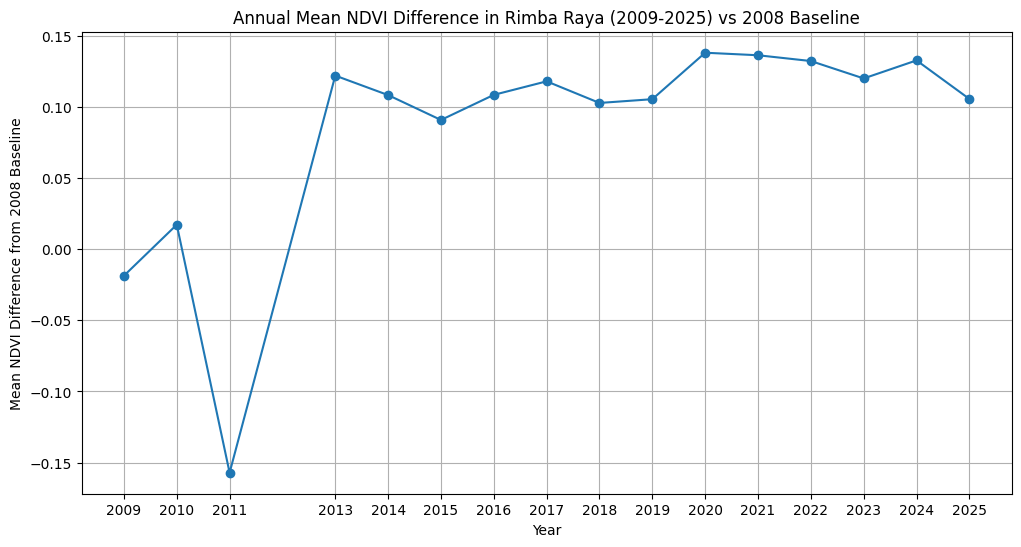

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the list of dictionaries to a pandas DataFrame.
df_ndvi_diff = pd.DataFrame(chart_data)

# Sort by year to ensure the time series is in order.
df_ndvi_diff = df_ndvi_diff.sort_values('year')

# Generate the time series chart.
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
plt.plot(df_ndvi_diff['year'], df_ndvi_diff['mean_ndvi_difference'], marker='o', linestyle='-')

# Add labels and title.
plt.xlabel('Year')
plt.ylabel('Mean NDVI Difference from 2008 Baseline')
plt.title('Annual Mean NDVI Difference in Rimba Raya (2009-2025) vs 2008 Baseline')
plt.grid(True)

# Set x-axis ticks to show each year clearly.
plt.xticks(df_ndvi_diff['year'])

# Display the plot.
plt.show()

In [12]:
# Investigate data availability and quality for 2012

# Filter the NDVI collection for the year 2012 and the AOI
ndvi_collection_2012 = ndvi_collection.filterDate('2012-01-01', '2012-12-31').filterBounds(aoi)

# Get the list of images in the filtered collection
image_list_2012 = ndvi_collection_2012.toList(ndvi_collection_2012.size())

# Get the client-side representation of the image list
client_image_list_2012 = image_list_2012.getInfo()

print(f"Number of images in the filtered collection for 2012: {len(client_image_list_2012)}")

if len(client_image_list_2012) > 0:
    print("Properties of images in the 2012 collection:")
    # Print properties for each image (e.g., system:index, CLOUD_COVER, IMAGE_QUALITY)
    for i, image_info in enumerate(client_image_list_2012):
        print(f"Image {i+1}:")
        # Access properties from the 'properties' key in the dictionary
        properties = image_info.get('properties', {})
        print(f"  System Index: {image_info.get('id', 'N/A')}")
        print(f"  Date: {properties.get('DATE_ACQUIRED', 'N/A')}")
        # Check for relevant properties based on Landsat collection (L5 has different property names than L8/L7)
        # For Landsat 5 (LT05/C02/T1_L2), look for 'CLOUD_COVER' and 'IMAGE_QUALITY_TIRS' (or similar)
        # For Landsat 8 (LC08/C02/T1_L2), look for 'CLOUD_COVER_LAND', 'CLOUD_COVER_AUTOMATED', 'QA_PIXEL' bits
        cloud_cover = properties.get('CLOUD_COVER', 'N/A') # Common for L5
        cloud_cover_land = properties.get('CLOUD_COVER_LAND', 'N/A') # Common for L8/L7
        qa_pixel_bits = properties.get('QA_PIXEL', 'N/A') # Relevant bits for cloud/shadow masking

        print(f"  Cloud Cover: {cloud_cover}")
        if cloud_cover_land != 'N/A':
             print(f"  Cloud Cover (Land): {cloud_cover_land}")
        if qa_pixel_bits != 'N/A':
             print(f"  QA_PIXEL: {qa_pixel_bits}") # This is the raw value, the mask function uses bits

        # You might need to adjust these based on the specific Landsat collection properties
        # print("  All Properties:")
        # pprint.pprint(properties) # Uncomment for detailed properties

else:
    print("No images found in the filtered collection for 2012.")

EEException: Collection.toList: The value of 'count' must be positive. Got: 0.

In [13]:
# --- Special Handling for 2012 with Less Strict Cloud Masking ---

# Define a less strict cloud mask function for Landsat 5 for investigation.
# This version might, for example, only mask definite clouds (bit 5) and not cloud shadows (bit 3),
# or use a different threshold if QA band values were being directly used.
# For this example, let's try only masking definite clouds (bit 5).
def less_strict_cloud_mask_l5(image):
  qa_pixel = image.select('QA_PIXEL')
  # Bit 5 is cloud.
  clouds_bitmask = 1 << 5
  # Flag should be zero, indicating clear conditions.
  mask = qa_pixel.bitwiseAnd(clouds_bitmask).eq(0)
  return image.updateMask(mask)

# Filter the raw Landsat 5 collection for the year 2012 and the AOI.
# Use the original collection before the strict cloud masking was applied.
raw_collection_l5_2012 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
  .filterDate('2012-01-01', '2012-12-31') \
  .filterBounds(aoi)

print(f'Raw L5 collection size for 2012: {raw_collection_l5_2012.size().getInfo()}')

# Apply scale factors and the less strict cloud mask to the 2012 collection.
processed_collection_l5_2012_less_mask = raw_collection_l5_2012 \
  .map(apply_scale_factors) \
  .map(less_strict_cloud_mask_l5) \
  .select(['SR_B4', 'SR_B3'], ['NIR', 'Red']) # Select only necessary bands before calculating NDVI

print(f'Processed L5 collection size for 2012 (less mask): {processed_collection_l5_2012_less_mask.size().getInfo()}')


# Calculate NDVI for the less-masked 2012 collection.
ndvi_collection_2012_less_mask = processed_collection_l5_2012_less_mask.map(calculate_ndvi).select('NDVI')

print(f'NDVI collection size for 2012 (less mask): {ndvi_collection_2012_less_mask.size().getInfo()}')

# Calculate the median NDVI for 2012 from the less-masked collection.
# Check if the collection is not empty before computing the median.
median_ndvi_2012_less_mask = ee.Algorithms.If(
    ndvi_collection_2012_less_mask.size().gt(0),
    ndvi_collection_2012_less_mask.median().select('NDVI'),
    ee.Image(None).rename('NDVI') # Return a masked image if no data
)

# Get the 2008 baseline NDVI image (from the previously computed dictionary).
# Ensure the key '2008' is used as a string to access the dictionary
ndvi_2008_baseline = ee.Image(annual_median_ndvi_images.get('2008'))

# Calculate the difference between the less-masked 2012 median NDVI and the 2008 baseline.
# Only attempt subtraction if the 2012 median image is not fully masked.
ndvi_difference_2012 = ee.Algorithms.If(
    ee.Image(median_ndvi_2012_less_mask).bandNames().contains('NDVI'), # Check if NDVI band exists (i.e., not fully masked)
    ee.Image(median_ndvi_2012_less_mask).subtract(ndvi_2008_baseline).rename('NDVI_Change').clip(aoi),
    ee.Image(None).rename('NDVI_Change') # Return a masked image if no 2012 data
)

# Calculate the mean NDVI difference within the AOI for 2012.
# Only attempt reduceRegion if the difference image is not fully masked.
mean_diff_2012 = ee.Algorithms.If(
    ee.Image(ndvi_difference_2012).bandNames().contains('NDVI_Change'), # Check if NDVI_Change band exists
    ee.Image(ndvi_difference_2012).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30, # Use appropriate scale
        maxPixels=1e9
    ).get('NDVI_Change'),
    None # Return None if no data for 2012 difference
)

# Fetch the mean difference for 2012 to the client side.
mean_diff_2012_value = mean_diff_2012.getInfo()

print(f'Mean NDVI difference for 2012 (less mask): {mean_diff_2012_value}')

# Add the 2012 data point to the existing chart_data list if a value was obtained.
# Ensure chart_data is defined (it should be from the previous cell run).
if 'chart_data' in globals() and mean_diff_2012_value is not None:
    # Check if 2012 is already in the list (shouldn't be if previous run excluded it, but good practice)
    if not any(d['year'] == 2012 for d in chart_data):
        chart_data.append({'year': 2012, 'mean_ndvi_difference': mean_diff_2012_value})
        print("Added 2012 data point to chart_data.")
    else:
        print("2012 data point already exists in chart_data (this is unexpected if the previous run excluded it).")
elif 'chart_data' not in globals():
    print("Error: chart_data variable not found. Please run the previous cell first.")
else:
    print("Mean NDVI difference for 2012 is None. Not adding to chart_data.")

# The next step will be to re-run the cell that generates the chart (cell 1a3cfad9).

Raw L5 collection size for 2012: 0
Processed L5 collection size for 2012 (less mask): 0
NDVI collection size for 2012 (less mask): 0
Mean NDVI difference for 2012 (less mask): None
Mean NDVI difference for 2012 is None. Not adding to chart_data.
